In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import glob,os,struct
import argparse
from colossus.cosmology import cosmology
import seaborn as sns
import matplotlib as mpl


In [2]:
# some constants and unit conversions
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3
yr_mks = 3.154e+7
c_mks = 3e8

Mpc_to_m = 3.086e+22
m_to_Mpc = 1./Mpc_to_m
s_to_year = 3.17098e-8
c_Mpc_yr = c_mks*m_to_Mpc/s_to_year

hh = 0.6774

In [9]:
# 348, 544, 660
snap=544
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_%03d_subfind'%snap)


# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('NfofGroups = %d'%Nfof)


# set-up cosmology
params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
cosmo = cosmology.setCosmology('myCosmo', params)

# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

----------PIG file info------------
Redshift = 1.00
NfofGroups = 173365484


In [10]:
pig2 = pig

In [12]:
# the most basic cut on stellar mass and Nbh
ngal = int(1e8) # this is sufficient
nbh = int(1e9)
#------------- Load data ------------------
gal_mass = pig2['SubGroups/SubhaloMassType'][:ngal][:,4] * 1e10/hh
sublen5 = pig2['SubGroups/SubhaloLenType'][:ngal][:, 5]
mask = gal_mass > 2e8
mask &= sublen5 > 0
gal_mass = gal_mass[mask]
sublen5 = sublen5[mask]
gal_nbh = sublen5

# other fields

gal_sfr = pig2['SubGroups/SubhaloSFR'][:ngal][mask]
gal_rhalf = pig2['SubGroups/SubhaloHalfmassRadType'][:ngal][mask, 4] / (1+redshift) # rhalf in ckpc/h for z=2 subfind

gal_mbh = pig2['SubGroups/SubhaloMassType'][:ngal][mask, 5] * 1e10/hh

suboff5 = pig2['SubGroups/SubhaloOffsetType'][:ngal][mask, 5]


suboff4 = pig2['SubGroups/SubhaloOffsetType'][:ngal][mask, 4]
sublen4 = pig2['SubGroups/SubhaloLenType'][:ngal][mask, 4]

gal_ssfr = gal_sfr/gal_mass


print(len(gal_mass))
ind = mask.nonzero()[0]
print(len(ind))

Ninit = len(ind)


1155863
1155863


In [14]:
# load BH properties
bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
bhgroup = pig2['5/GroupID'][:nbh] - 1
bhid = pig2['5/ID'][:nbh]

gal_m5 = np.array([np.sum(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])

gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


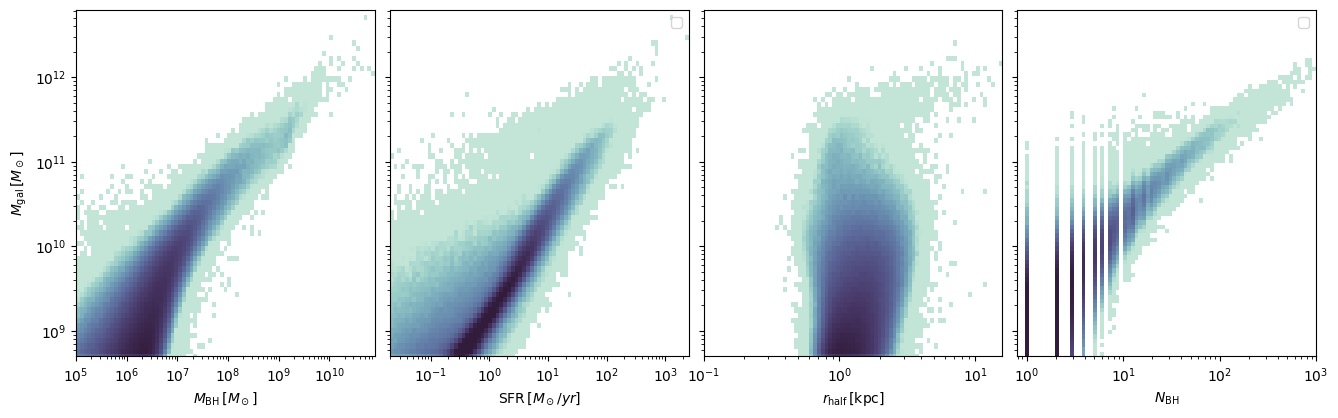

In [ ]:
cc = sns.cubehelix_palette(as_cmap=True)
cc2 = sns.cubehelix_palette(as_cmap=True,rot=-.4)
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)



fig, ax = plt.subplots(1,4,figsize=(16,4.5), sharey=True)
plt.subplots_adjust(wspace=0.05)
ax = ax.flatten()


# ---------------- Mgal_Mbh -------------------------
mask1 = gal_m5 > gal_mass/10
mask2 = (gal_mass > gal_m5 * 5000)
mask2 &= gal_mass > 1e11 

mask = ~(mask1 | mask2)

xmin, xmax = 5, 10.9
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax[0].hist2d(gal_m5[mask], gal_mass[mask], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[0].set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[0].set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')



# ---------------- Mgal_sfr -------------------------
xmin, xmax = -1.7, 3.4
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80) 
ybins = np.logspace(ymin,ymax, 80)
ax[1].hist2d(gal_sfr, gal_mass, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[1].set(xscale='log', yscale='log',xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[1].set(xlabel=r'${\rm SFR}\,[M_\odot/yr]$')
ax[1].legend(markerscale=20)
# legend.legendHandles[0]._legmarker.set_markersize(15)

# ---------------- Mgal_reff -------------------------
xmin, xmax = -1, 1.2
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax[2].hist2d(gal_rhalf, gal_mass, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[2].set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[2].set(xlabel=r'$r_{\rm half}\,[{\rm kpc}]$')



# ---------------- Mgal_Nbh -------------------------
xmin, xmax = -0.1, 3.
ymin, ymax = 8.7, 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax[3].hist2d(gal_nbh, gal_mass, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[3].set(xscale='log', yscale='log',xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[3].set(xlabel=r'$N_{\rm BH}$')
ax[3].legend()

# plt.savefig('figures/z2_population_selection.png', bbox_inches='tight', dpi=140, facecolor='white', transparent=False)

plt.show()


### previous catalog

In [25]:
path = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat/"
cat_z2 = np.load(path + "lisa_mbhcat_single_v2.1_z2.npy")
cat_z1 = np.load(path + "lisa_mbhcat_single_v2.1_z1.npy")
cat_z5 = np.load(path + "lisa_mbhcat_single_v2.1_z5.npy")




In [23]:
print(cat_z2.dtype)

[('bidx', '<i4'), ('bhmass', '<f8'), ('mstot', '<f8'), ('mdm', '<f8'), ('mdot', '<f8')]


[Text(0.5, 0, '$M_{\\rm BH}\\,[M_\\odot]$'),
 Text(0, 0.5, '$M_{\\rm gal}\\,[M_\\odot]$')]

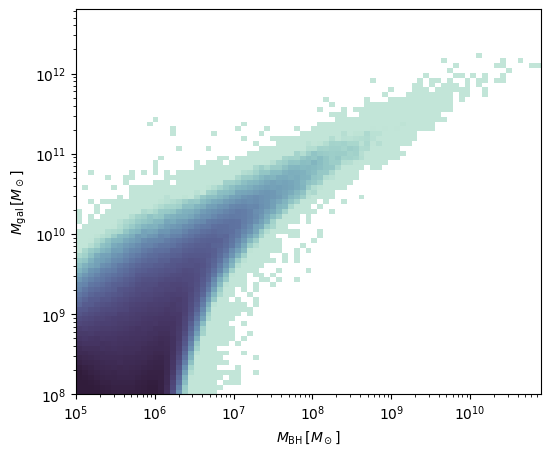

In [24]:
cat = cat_z2

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
xmin, xmax = 5, 10.9
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax.hist2d(cat["bhmass"], cat["mstot"], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax.set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax.set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')
plt.show()


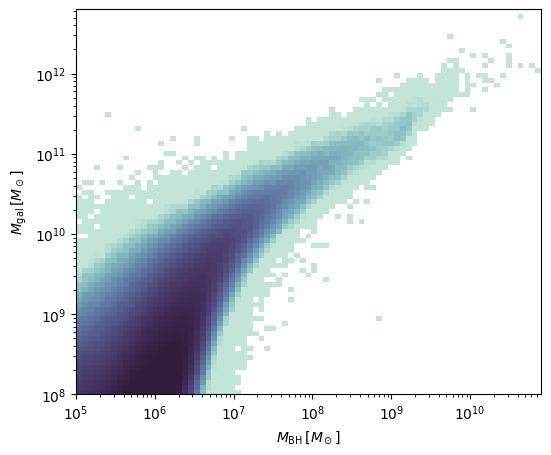

In [26]:
cat = cat_z1

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
xmin, xmax = 5, 10.9
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax.hist2d(cat["bhmass"], cat["mstot"], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax.set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax.set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')
plt.show()


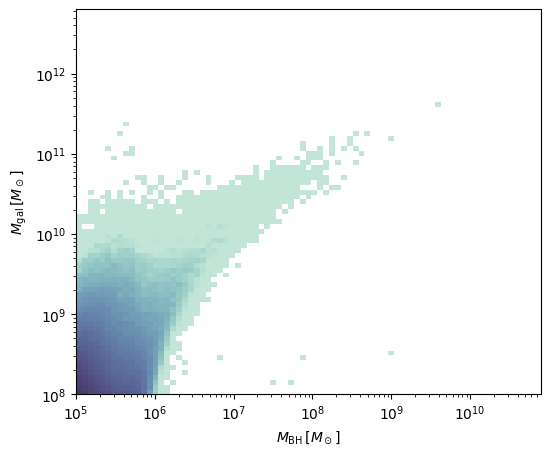

In [27]:
cat = cat_z5

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
xmin, xmax = 5, 10.9
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax.hist2d(cat["bhmass"], cat["mstot"], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax.set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax.set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')
plt.show()
